# About the notebook
This script contains calculations to compare the GC correction values calculated by deepTools and by the cfDAN-Unilflow implementation as well as the different smoothings.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_subframes(input_file):
    data_df = pd.read_csv(input_file, sep="\t",index_col=[0,1])
    F_gc_df = data_df.loc["F_gc"]
    N_gc_df = data_df.loc["N_gc"]
    R_gc_df = data_df.loc["R_gc"]
    return F_gc_df, N_gc_df, R_gc_df

def get_subframes_unsmoothed(input_file):
    data_df = pd.read_csv(input_file, sep="\t",index_col=[0,1])
    F_gc_df = data_df.loc["F_gc"]
    N_gc_df = data_df.loc["N_gc"]
    return F_gc_df, N_gc_df

In [3]:
def median_smoothing(current,fraction):
    bin_size=int(len(current)*fraction)
    if bin_size<50:
        bin_size=50
    medians = []

    for i in range(len(current)):
        start = int(i-bin_size/2)
        end = int(i+bin_size/2)
        #if the bin starts before the beginning, just take the first bin
        if start<0:
            start=0
            end=bin_size
        #if the bin extends beyond the end, take the last bin
        if end>=len(current):
            start=len(current)-bin_size
            end=len(current)
        current_median = np.nanmedian(current['GC_bias'].iloc[start:end])
        medians.append(current_median)
    return(medians)

In [4]:
def get_ratio(N_GC,F_GC):
    #N_GC = df.loc["N_gc"]
    #F_GC = df.loc["F_gc"]
    
    scaling_dict = dict()
    for i in N_GC.index:
        n_tmp = N_GC.loc[i].to_numpy()
        f_tmp = F_GC.loc[i].to_numpy()
        scaling_dict[i] = float(np.sum(n_tmp)) / float(np.sum(f_tmp))


    r_dict = dict()
    for i in N_GC.index:
        scaling = scaling_dict[i]
        f_gc_t = F_GC.loc[i]
        n_gc_t = N_GC.loc[i]
        r_gc_t = np.array([float(f_gc_t[x]) / n_gc_t[x] * scaling
                           if n_gc_t[x] and f_gc_t[x] > 0 else 1
                           for x in range(len(f_gc_t))])
        r_dict[i] = r_gc_t
    
    ratio_dense = pd.DataFrame.from_dict(r_dict, orient="index", columns=N_GC.columns)
    ind = pd.MultiIndex.from_product([ratio_dense.index])
    ratio_dense.index = ind

    return ratio_dense

In [5]:
def make_GC_heatmap(F_GC, N_GC, R_GC, sample_name, quantile_threshold=None):
    
    # extract max readlen
    N_GC_min, N_GC_max =  np.nanmin(N_GC.index), np.nanmax(N_GC.index)
    
    # prepare data
    N_a_CSAPS,N_b_CSAPS = np.meshgrid(N_GC.columns.to_numpy(dtype=int), N_GC.index.to_numpy(dtype=int))
    N_c_CSAPS = N_GC.to_numpy()
    if quantile_threshold:
        N_l_c_CSAPS,N_r_c_CSAPS  = np.nanmin(N_c_CSAPS), np.quantile(N_c_CSAPS, quantile_threshold)
    else:
        N_l_c_CSAPS,N_r_c_CSAPS  = np.nanmin(N_c_CSAPS), np.nanmax(N_c_CSAPS)

    F_a_CSAPS,F_b_CSAPS = np.meshgrid(F_GC.columns.to_numpy(dtype=int), F_GC.index.to_numpy(dtype=int))
    F_c_CSAPS = F_GC.to_numpy()
    if quantile_threshold:
        F_l_c_CSAPS,F_r_c_CSAPS  = np.nanmin(F_c_CSAPS), np.quantile(F_c_CSAPS, quantile_threshold)
    else:
        F_l_c_CSAPS,F_r_c_CSAPS  = np.nanmin(F_c_CSAPS), np.nanmax(F_c_CSAPS)
    
    R_a_CSAPS,R_b_CSAPS = np.meshgrid(R_GC.columns.to_numpy(dtype=int), R_GC.index.to_numpy(dtype=int))
    R_c_CSAPS = R_GC.to_numpy()
    if quantile_threshold:
        R_l_c_CSAPS,R_r_c_CSAPS  = np.nanmin(R_c_CSAPS), np.quantile(R_c_CSAPS, quantile_threshold)
    else:
        R_l_c_CSAPS,R_r_c_CSAPS  = np.nanmin(R_c_CSAPS), np.nanmax(R_c_CSAPS)
        
    
    fig_GC_interpolation_heatmap, axes = plt.subplots(ncols=3, nrows=1, figsize=(30, 12))

    fig_GC_interpolation_heatmap.suptitle(f'GC bias: {sample_name}')
    
    pcm = axes[0].axes.pcolormesh(N_a_CSAPS, N_b_CSAPS, N_c_CSAPS, vmin=N_l_c_CSAPS, vmax=N_r_c_CSAPS, shading="nearest", cmap="viridis")
    axes[0].set_title('N_GC: CSAPS')
    axes[0].axes.set_yticks(np.arange(N_GC_min,N_GC_max+1,5))
    fig_GC_interpolation_heatmap.colorbar(pcm, ax=axes[0])
    
    # plot F_GC interpolant with all default zero
    
    pcm = axes[1].axes.pcolormesh(F_a_CSAPS, F_b_CSAPS, F_c_CSAPS, vmin=F_l_c_CSAPS, vmax=F_r_c_CSAPS, shading="nearest", cmap="viridis")
    axes[1].set_title('F_GC: CSAPS')
    axes[1].axes.set_yticks(np.arange(N_GC_min,N_GC_max+1,5))
    fig_GC_interpolation_heatmap.colorbar(pcm, ax=axes[1])
    
    # plot ratio with all default zero
    
    pcm = axes[2].axes.pcolormesh(R_a_CSAPS, R_b_CSAPS, R_c_CSAPS, vmin=R_l_c_CSAPS, vmax=R_r_c_CSAPS, shading="nearest", cmap="viridis")
    axes[2].set_title('ratio: CSAPS')
    axes[2].axes.set_yticks(np.arange(N_GC_min,N_GC_max+1,5))
    fig_GC_interpolation_heatmap.colorbar(pcm, ax=axes[2])
    plt.tight_layout()
    
    return fig_GC_interpolation_heatmap


In [6]:
def main(input_file, sample_name, quantile_threshold, output_file):
    """Loads GC_bias file (TSV with first two rows being a multiindex for category (N_GC,F_GC,R_GC) and fragmentlength),
     creates a heatmap for each and saves the results as a combine plot.

    Args:
        input_file (_type_): _description_
        sample_name (_type_): _description_
        quantile_threshold (_type_): _description_
        output_file (_type_): _description_
    """
    # load data
    F_gc_df, N_gc_df, R_gc_df = get_subframes(input_file=input_file)
    
    # make figure
    fig = make_GC_heatmap(F_GC=F_gc_df, N_GC=N_gc_df, R_GC=R_gc_df, sample_name=sample_name, quantile_threshold=quantile_threshold)
    
    # save figure
    fig.get_figure().savefig(output_file)

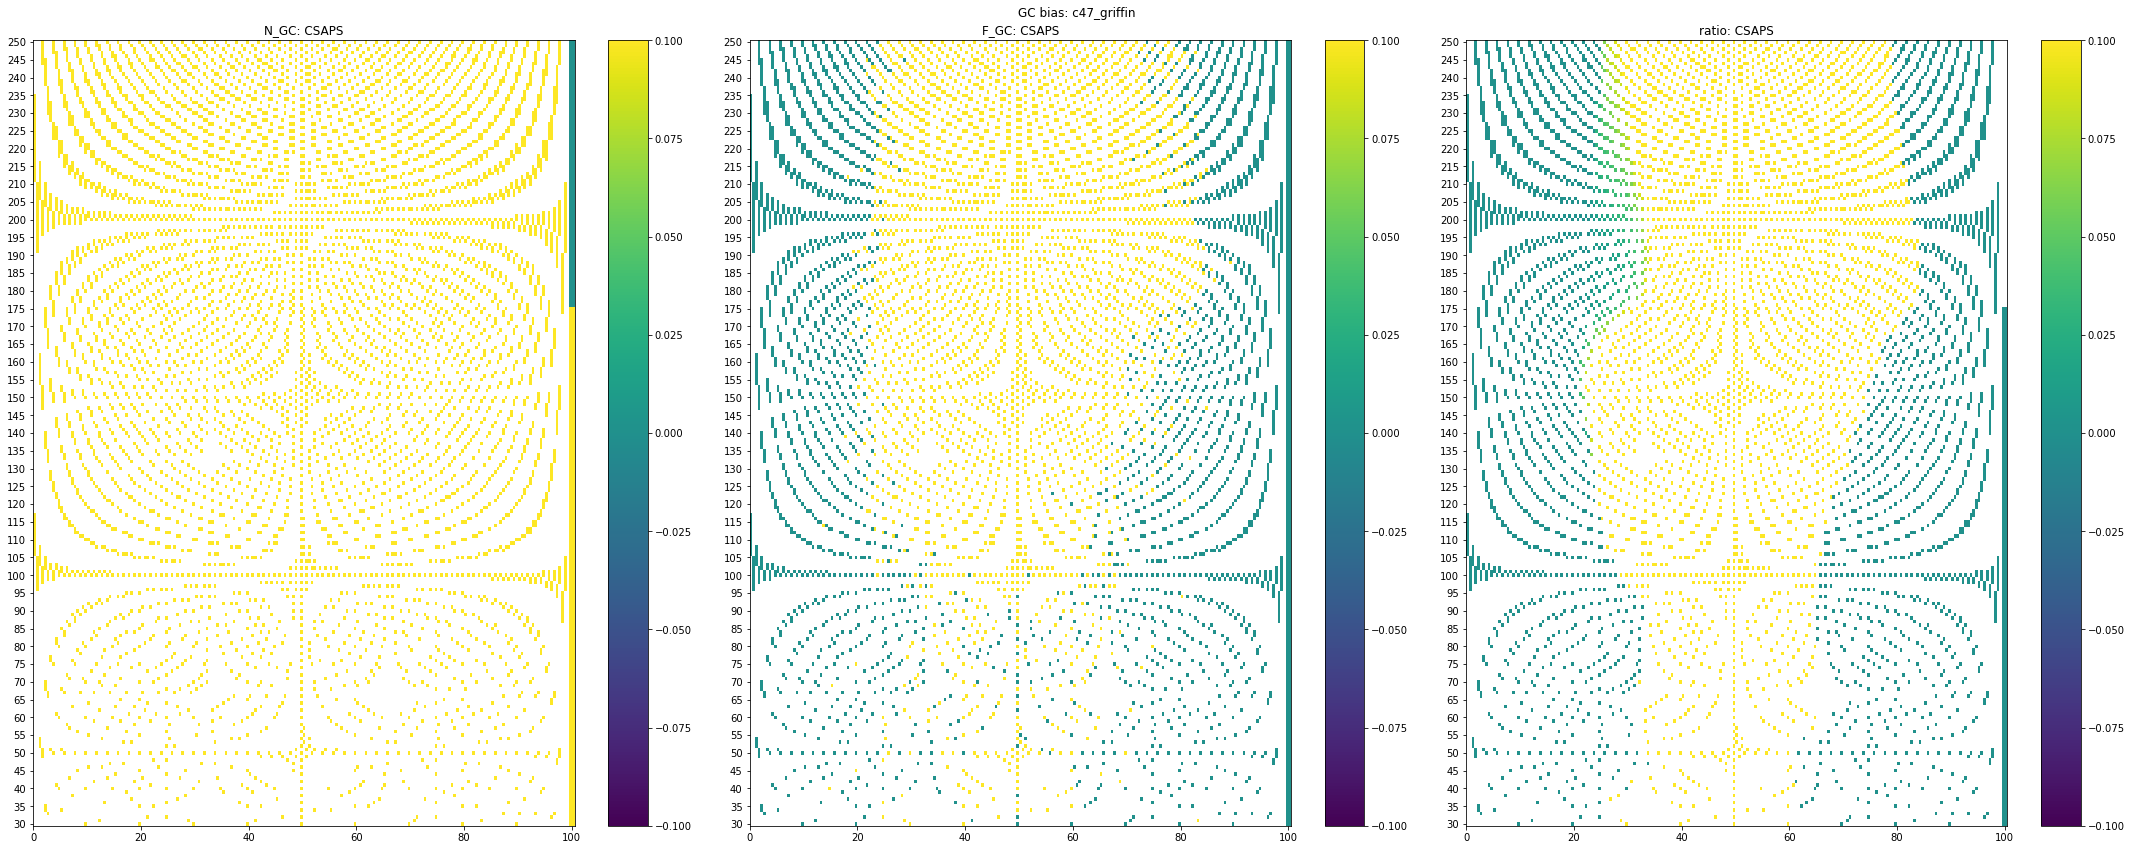

In [7]:
### read in griffin data

path = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/Griffin/run_griffin_demo/griffin_GC_correction/results/repeat_masker.mapable.k50.Umap.hg38/GC_bias/c_47_sizeRange.GC_bias.txt"
griffin_c47 = pd.read_csv(path, sep="\t")
griffin_c47["GC_percent"] = griffin_c47["num_GC"]/griffin_c47["length"]*100


# make F_gc_df, N_gc_df, R_gc_df tables for griffin and heatmap

F_gc_df = pd.DataFrame(index=np.arange(0.0, 100.1, 0.1).round(1))
N_gc_df = pd.DataFrame(index=np.arange(0.0, 100.1, 0.1).round(1))
R_gc_df = pd.DataFrame(index=np.arange(0.0, 100.1, 0.1).round(1))

F_gc_df["start"] = 1
N_gc_df["start"] = 1
R_gc_df["start"] = 1

for i in range(30,251):
    fragment_counts = griffin_c47[griffin_c47["length"] == i][["GC_percent","number_of_fragments"]]
    fragment_counts["GC_percent"] = fragment_counts["GC_percent"].round(1)
    fragment_counts = fragment_counts.set_index("GC_percent")
    F_gc_df[i] = fragment_counts
    
    genomic_counts = griffin_c47[griffin_c47["length"] == i][["GC_percent","number_of_positions"]]
    genomic_counts["GC_percent"] = genomic_counts["GC_percent"].round(1)
    genomic_counts = genomic_counts.set_index("GC_percent")
    N_gc_df[i] = genomic_counts
    
    smoothed_gc_bias = griffin_c47[griffin_c47["length"] == i][["GC_percent","smoothed_GC_bias"]]
    smoothed_gc_bias["GC_percent"] = smoothed_gc_bias["GC_percent"].round(1)
    smoothed_gc_bias = smoothed_gc_bias.set_index("GC_percent")
    R_gc_df[i] = smoothed_gc_bias
    
F_gc_df = F_gc_df.iloc[:,1:].T
N_gc_df = N_gc_df.iloc[:,1:].T
R_gc_df = R_gc_df.iloc[:,1:].T

sample_name = "c47_griffin"
quantile_threshold = 0.95
fig = make_GC_heatmap(F_GC=F_gc_df, N_GC=N_gc_df, R_GC=R_gc_df, sample_name=sample_name, quantile_threshold=quantile_threshold)

In [8]:
### import the raw data from deepTools counts and prepare it so the Griffin smoothing pipeline can be applied ###

size_range_min = 30
size_range_max = 250

path = "/fast/work/groups/ag_kircher/cfDNA-analysis/sebastian/develop/GC_correction_workflow/results/intermediate/samples_Lea/GCcorrect/hg38/EGAF00002727463_GCbias_measured_CSAPS_nofilter.tsv.gz"
F_gc_df_mine, N_gc_df_mine = get_subframes_unsmoothed(path)

R_gc_GC_df = pd.DataFrame()
R_gc_GC_freq = pd.DataFrame()

count = 0
for i in range(size_range_min, size_range_max+1,5):
    # GC_df
    df = pd.DataFrame()
    df["number_of_fragments"] = F_gc_df_mine.iloc[count,:]
    #print(F_gc_df_mine.iloc[count,:])
    df["length"] = i
    df = df.reset_index(drop=False)
    df.rename(columns = {'index':'num_GC'}, inplace = True)
    df['num_GC'] = df['num_GC'].astype(int)
    
    # GC_freq
    freq = pd.DataFrame()
    freq["number_of_fragments"] = N_gc_df_mine.iloc[count,:]
    #print(N_gc_df_mine.iloc[count,:])
    freq["length"] = i
    freq = freq.reset_index(drop=False)
    freq.rename(columns = {'index':'num_GC'}, inplace = True)
    freq['num_GC'] = freq['num_GC'].astype(int)
    
    R_gc_GC_df = pd.concat([R_gc_GC_df, df], axis=0)
    R_gc_GC_freq = pd.concat([R_gc_GC_freq, freq], axis=0)
    count += 1
    

R_gc_GC_df = R_gc_GC_df.reset_index(drop=True)
R_gc_GC_freq = R_gc_GC_freq.reset_index(drop=True)

In [9]:
### smooth the deepTools raw data with Griffin pipeline ###

# params
size_range_min = 30
size_range_max = 250
genome_GC_frequency = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/Griffin/Ref/genome_GC_frequency"
mapable_name = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/Griffin/Ref/repeat_masker.mapable.k50.Umap.hg38.bedGraph".rsplit('/',1)[1].rsplit('.',1)[0]
frequency_prefix = genome_GC_frequency+'/'+mapable_name+'.'

#calculate the GC_bias
new_df = pd.DataFrame()
for length in range(size_range_min,size_range_max+1,5):
    current = R_gc_GC_df[R_gc_GC_df['length']==length].copy().reset_index(drop=True)
    current_freq = R_gc_GC_freq[R_gc_GC_freq['length']==length].copy().reset_index(drop=True)
    
    #save the frequency of each GC content in the genome
    current['number_of_positions']=current_freq['number_of_fragments']
    
    #calculate the GC bias
    current_bias = current['number_of_fragments']/current['number_of_positions']    
    current['GC_bias'] = current_bias

    #normalize to a mean of 1 for each fragment length(compute GC bias does this same thing)
    current['GC_bias'] = current['GC_bias']/np.nanmean(current['GC_bias'])
    new_df = new_df.append(current, ignore_index=True)
    
new_df = new_df.sort_values(by=['length','num_GC']).reset_index(drop=True)

#smooth GC bias by size bin
GC_smoothing_step = 20 #For now I'm going to keep the smoothing bin size as a set variable
new_df2 = pd.DataFrame()
for length in new_df['length'].unique():        
    
    #get a bin of similar sized fragments
    min_len = int(length - (GC_smoothing_step/2))
    max_len = int(length + (GC_smoothing_step/2))
    
    current = new_df[(new_df['length']>=min_len) & (new_df['length']<=max_len)].copy()

    #perform smoothing
    fit = median_smoothing(current,.05)  
    current['smoothed_GC_bias']=fit
    
    #only keep smoothed values for the selected length
    current = current[current['length']==length]
    
    #get rid of values for GC contents that are never observed
    current['smoothed_GC_bias'] = np.where(current['number_of_positions']==0,np.nan,current['smoothed_GC_bias'])
    
    #normalize to a mean of 1
    current['smoothed_GC_bias'] = current['smoothed_GC_bias']/np.nanmean(current['smoothed_GC_bias'])
    #current['smoothed_GC_bias'] = 1
    
    new_df2 = new_df2.append(current,ignore_index=True)
    
new_df_mine = new_df2

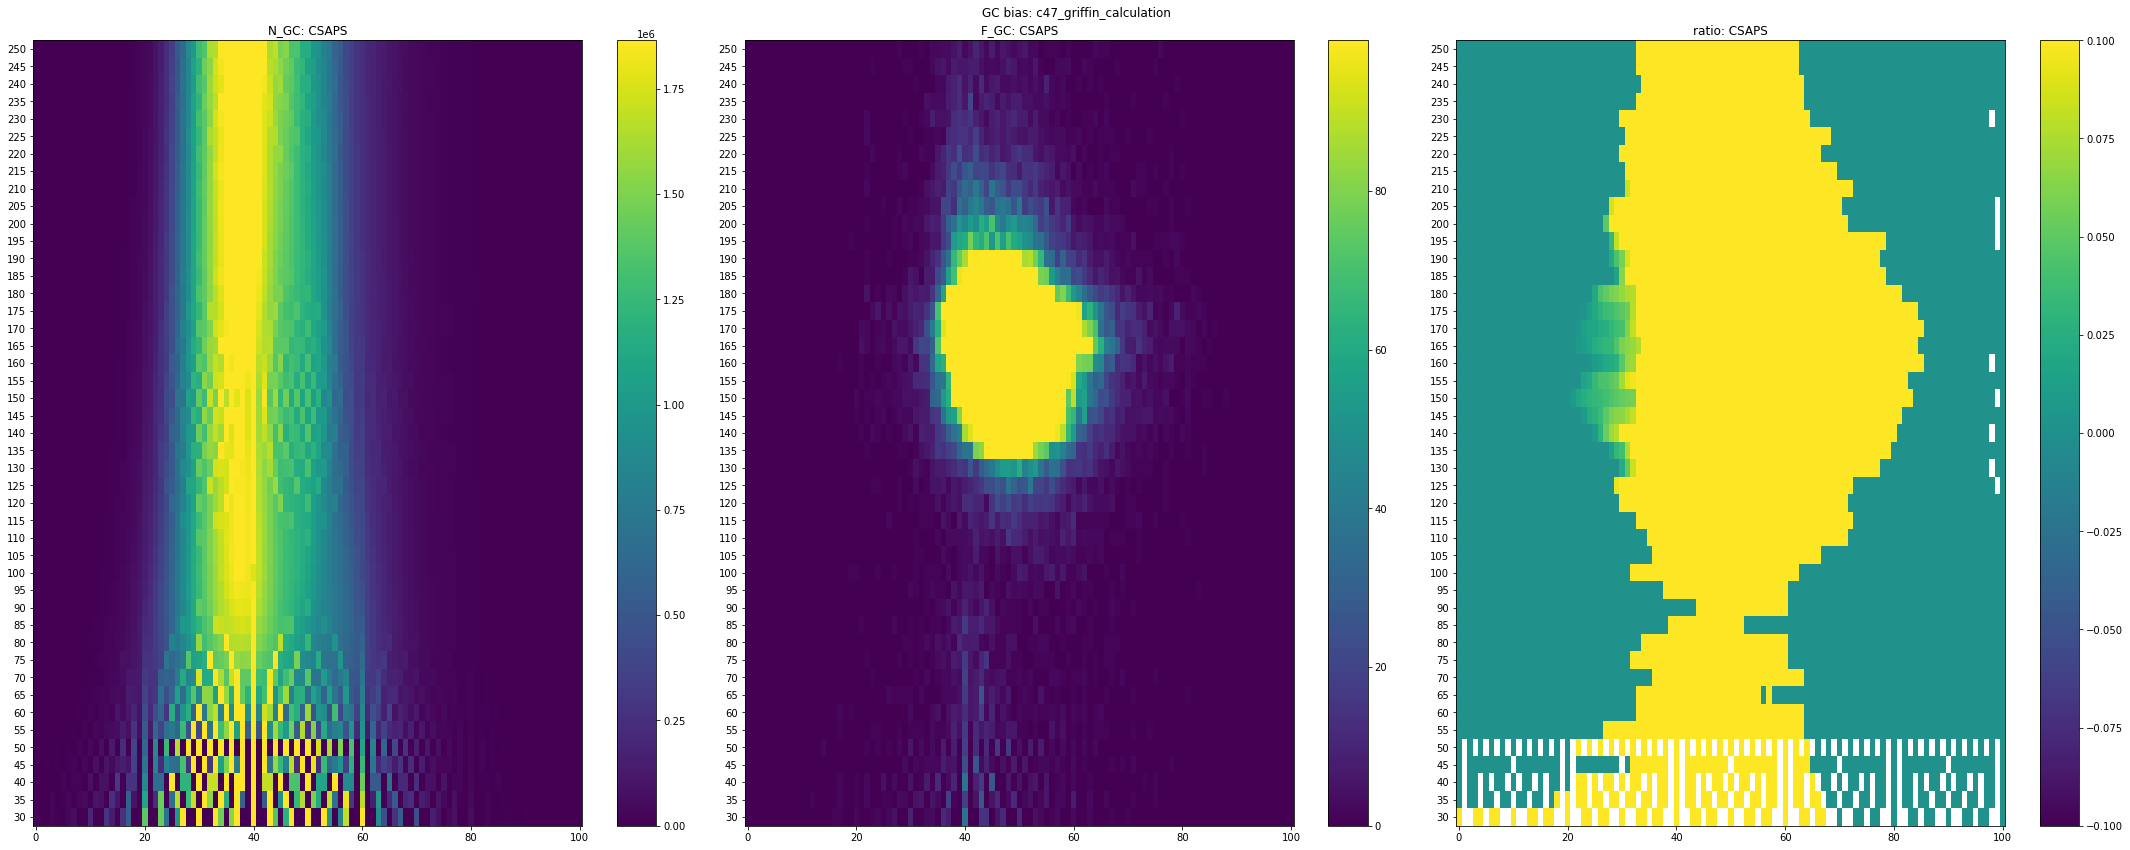

In [10]:
# make R_gc_df tables for mine with griffin normalization

R_gc_df_mine = pd.DataFrame(index=range(0,101))

for i in range(size_range_min,size_range_max+1,5):
    smoothed_gc_bias = new_df_mine[new_df_mine["length"] == i][["num_GC","smoothed_GC_bias"]]
    smoothed_gc_bias = smoothed_gc_bias.set_index("num_GC")
    R_gc_df_mine[i] = smoothed_gc_bias
    
R_gc_df_mine = R_gc_df_mine.T

sample_name = "c47_griffin_calculation"
quantile_threshold = 0.95
fig = make_GC_heatmap(F_GC=F_gc_df_mine, N_GC=N_gc_df_mine, R_GC=R_gc_df_mine, sample_name=sample_name, quantile_threshold=quantile_threshold)


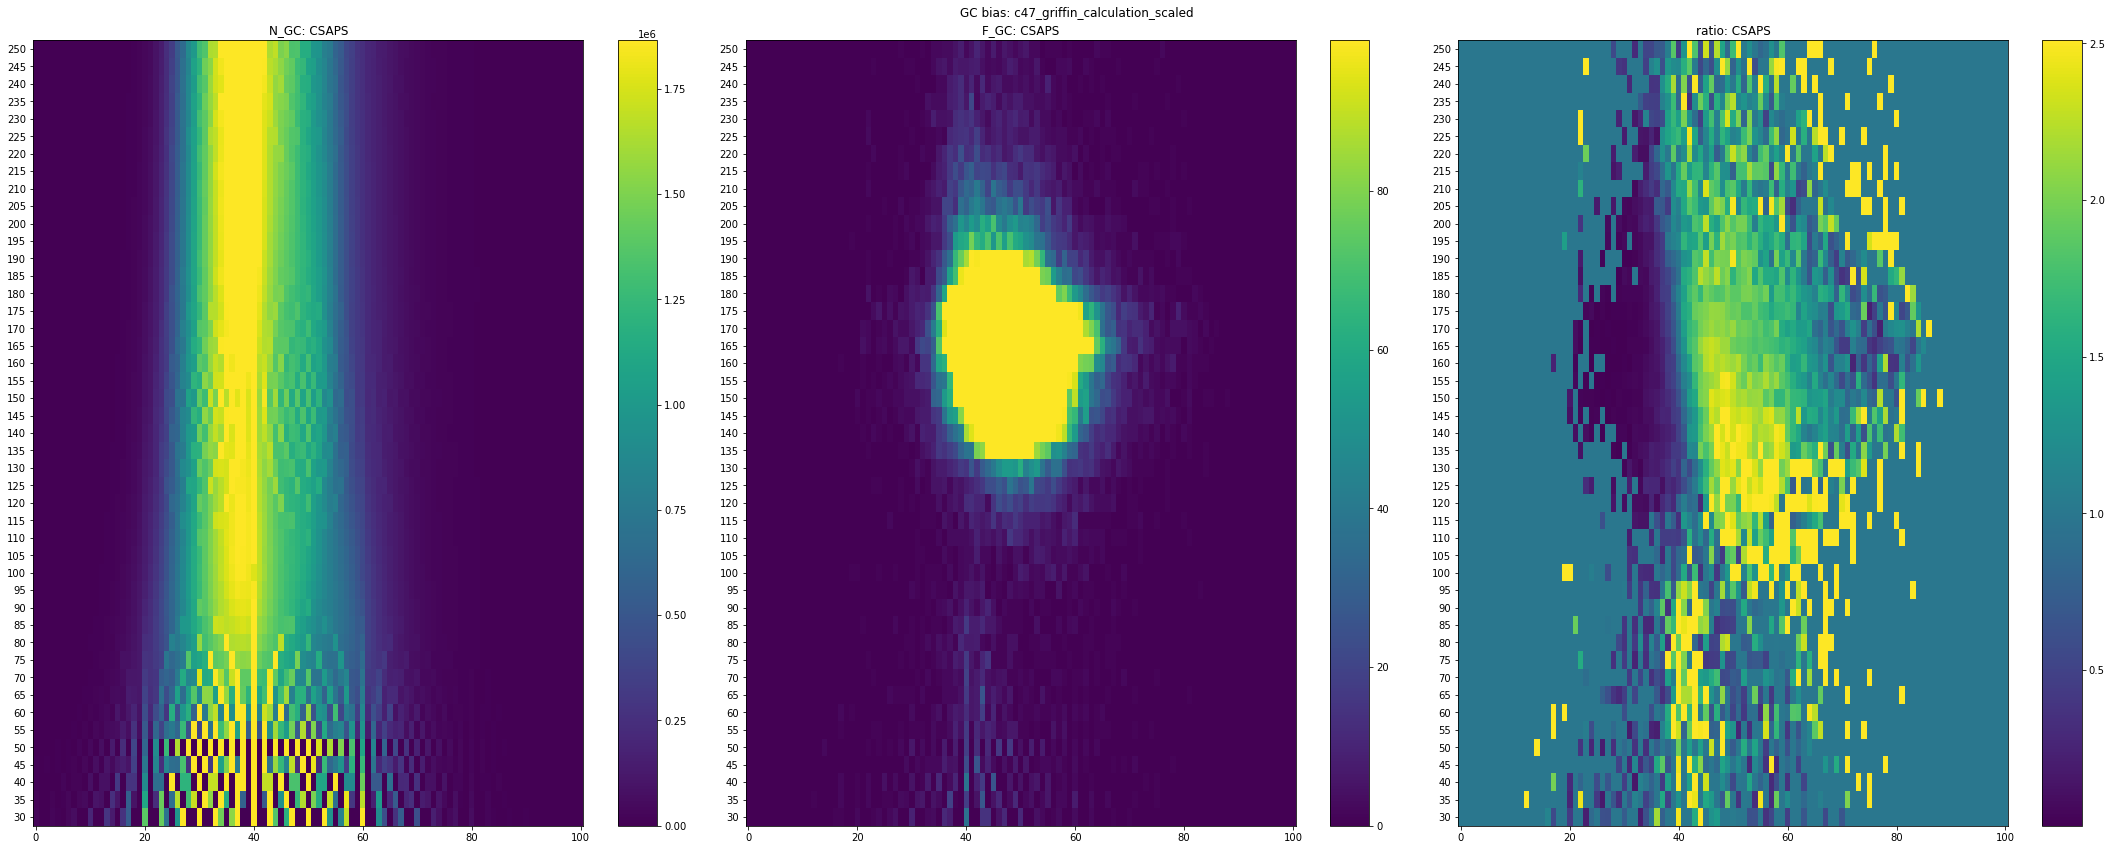

In [11]:
### correction factors with scaling

R_df = get_ratio(N_gc_df_mine,F_gc_df_mine)
R_df = R_df.reset_index(drop = False)
R_df = R_df.set_index("level_0")

# make figure
sample_name = "c47_griffin_calculation_scaled"
quantile_threshold = 0.95
fig = make_GC_heatmap(F_GC=F_gc_df_mine, N_GC=N_gc_df_mine, R_GC=R_df, sample_name=sample_name, quantile_threshold=quantile_threshold)


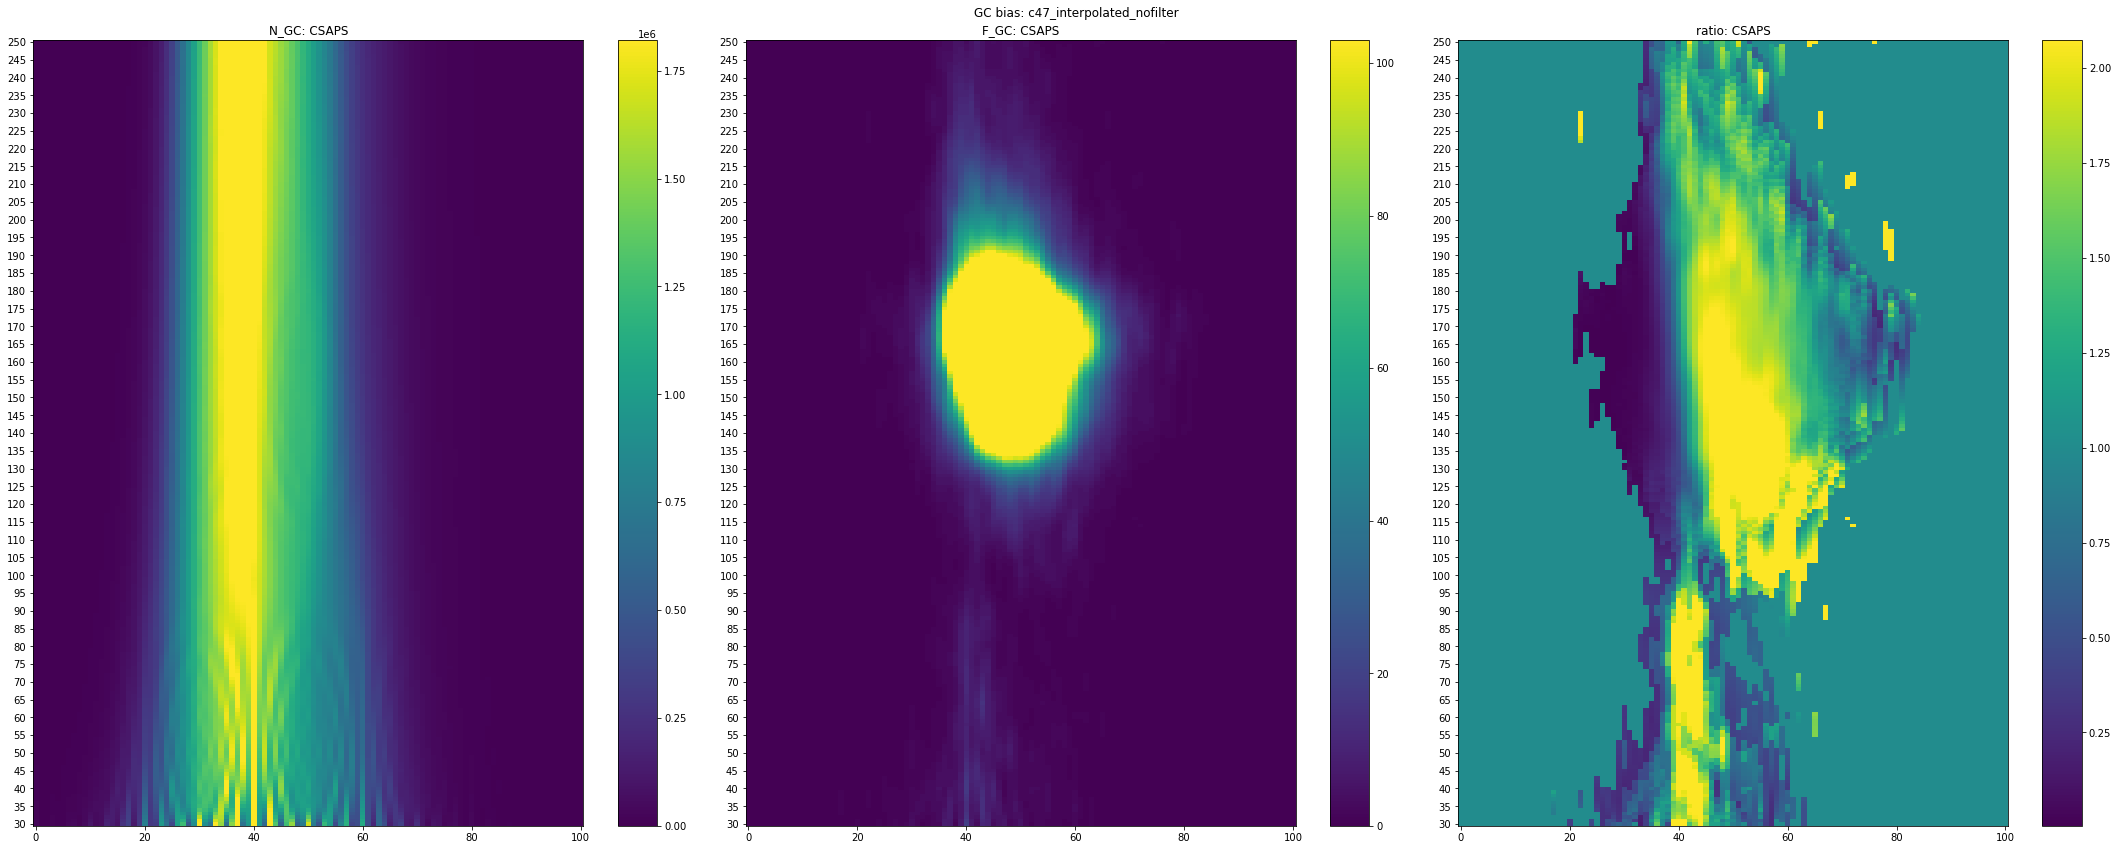

In [12]:
### deepTools results
in_file = "/fast/work/groups/ag_kircher/cfDNA-analysis/sebastian/develop/GC_correction_workflow/results/intermediate/samples_Lea/GCcorrect/hg38/EGAF00002727463_GCbias_interpolated_CSAPS_nofilter.tsv.gz"
sample = "c47_interpolated_nofilter"
q_thresh = 0.95
out_file = "c47_GCbias_interpolated_CSAPS_nofilter.png"


if __name__ == "__main__":
    main(in_file, sample, q_thresh, out_file)